<a href="https://colab.research.google.com/github/nikitazhuikov/Kaggle/blob/main/EDA_house_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.sql.functions as f
import seaborn as sns
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType

In [86]:
from pyspark.sql import SparkSession


# Создаем SparkSession
spark = (
    SparkSession.builder
    .appName("My PySpark Application")   # Название приложения
    .master("local[*]")   # Указывает использовать локальный режим со всеми ядрами
    .config("spark.executor.memory", "2g")   # Настройка памяти для исполнителей
    .config("spark.driver.memory", "2g")   # Настройка памяти для драйвера
    .config("spark.sql.debug.maxToStringFields", 1000)
    .getOrCreate()
)

# Проверка успешного подключения
print("Spark Version:", spark.version)

Spark Version: 3.5.5


### Загрузка данных

In [87]:
df = spark.read.csv("Housing.csv", header=True, inferSchema=True)

In [88]:
df.show(5)

+--------+----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+
|   price|area|bedrooms|bathrooms|stories|mainroad|guestroom|basement|hotwaterheating|airconditioning|parking|prefarea|furnishingstatus|
+--------+----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+
|13300000|7420|       4|        2|      3|     yes|       no|      no|             no|            yes|      2|     yes|       furnished|
|12250000|8960|       4|        4|      4|     yes|       no|      no|             no|            yes|      3|      no|       furnished|
|12250000|9960|       3|        2|      2|     yes|       no|     yes|             no|             no|      2|     yes|  semi-furnished|
|12215000|7500|       4|        2|      2|     yes|       no|     yes|             no|            yes|      3|     yes|       furnished|
|11410000|7420|       4|        1|      2

### Характеристика данных

In [89]:
df.summary().show()

+-------+------------------+------------------+------------------+------------------+------------------+--------+---------+--------+---------------+---------------+------------------+--------+----------------+
|summary|             price|              area|          bedrooms|         bathrooms|           stories|mainroad|guestroom|basement|hotwaterheating|airconditioning|           parking|prefarea|furnishingstatus|
+-------+------------------+------------------+------------------+------------------+------------------+--------+---------+--------+---------------+---------------+------------------+--------+----------------+
|  count|               545|               545|               545|               545|               545|     545|      545|     545|            545|            545|               545|     545|             545|
|   mean| 4766729.247706422|  5150.54128440367|2.9651376146788992|1.2862385321100918|1.8055045871559634|    NULL|     NULL|    NULL|           NULL|           N

In [90]:
df.printSchema()
num_rows = df.count()
num_cols = len(df.columns)
print(f"Number of rows: {num_rows}, Number of columns: {num_cols}")

root
 |-- price: integer (nullable = true)
 |-- area: integer (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: integer (nullable = true)
 |-- stories: integer (nullable = true)
 |-- mainroad: string (nullable = true)
 |-- guestroom: string (nullable = true)
 |-- basement: string (nullable = true)
 |-- hotwaterheating: string (nullable = true)
 |-- airconditioning: string (nullable = true)
 |-- parking: integer (nullable = true)
 |-- prefarea: string (nullable = true)
 |-- furnishingstatus: string (nullable = true)

Number of rows: 545, Number of columns: 13


### Поиск отсутствующих значений

In [91]:
missing_values = df.select([sum(f.col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_values.show()

+-----+----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+
|price|area|bedrooms|bathrooms|stories|mainroad|guestroom|basement|hotwaterheating|airconditioning|parking|prefarea|furnishingstatus|
+-----+----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+
|    0|   0|       0|        0|      0|       0|        0|       0|              0|              0|      0|       0|               0|
+-----+----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+



In [92]:
print(col('price').isNull()) # Подумать еще

Column<'(price IS NULL)'>


### Дополнение пустыми значениями

In [93]:
schema = StructType([StructField('price', IntegerType(), True),
                     StructField('area', IntegerType(), True),
                     StructField('bedrooms', IntegerType(), True),
                     StructField('bathrooms', IntegerType(), True),
                     StructField('stories', IntegerType(), True),
                     StructField('mainroad', StringType(), True),
                     StructField('guestroom', StringType(), True),
                     StructField('basement', StringType(), True),
                     StructField('hotwaterheating', StringType(), True),
                     StructField('airconditioning', StringType(), True),
                     StructField('parking', IntegerType(), True),
                     StructField('prefarea', StringType(), True),
                     StructField('furnishingstatus', StringType(), True)
])
df1 = spark.createDataFrame([(4340000, None, 3, None, 2, 'yes', None, None, 'no', None, None, None, None),
                             (4000000, None, 3, None, 2, None, None, None, None, None, None, None, None),
                             (None, 5000, 3, None, 2, None, 'no', None, None, None, None, 'yes', 'furnished')], schema=schema)
df1.show()

+-------+----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+
|  price|area|bedrooms|bathrooms|stories|mainroad|guestroom|basement|hotwaterheating|airconditioning|parking|prefarea|furnishingstatus|
+-------+----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+
|4340000|NULL|       3|     NULL|      2|     yes|     NULL|    NULL|             no|           NULL|   NULL|    NULL|            NULL|
|4000000|NULL|       3|     NULL|      2|    NULL|     NULL|    NULL|           NULL|           NULL|   NULL|    NULL|            NULL|
|   NULL|5000|       3|     NULL|      2|    NULL|       no|    NULL|           NULL|           NULL|   NULL|     yes|       furnished|
+-------+----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+



In [94]:
df = df.union(df1)
df.tail(5)

[Row(price=1750000, area=2910, bedrooms=3, bathrooms=1, stories=1, mainroad='no', guestroom='no', basement='no', hotwaterheating='no', airconditioning='no', parking=0, prefarea='no', furnishingstatus='furnished'),
 Row(price=1750000, area=3850, bedrooms=3, bathrooms=1, stories=2, mainroad='yes', guestroom='no', basement='no', hotwaterheating='no', airconditioning='no', parking=0, prefarea='no', furnishingstatus='unfurnished'),
 Row(price=4340000, area=None, bedrooms=3, bathrooms=None, stories=2, mainroad='yes', guestroom=None, basement=None, hotwaterheating='no', airconditioning=None, parking=None, prefarea=None, furnishingstatus=None),
 Row(price=4000000, area=None, bedrooms=3, bathrooms=None, stories=2, mainroad=None, guestroom=None, basement=None, hotwaterheating=None, airconditioning=None, parking=None, prefarea=None, furnishingstatus=None),
 Row(price=None, area=5000, bedrooms=3, bathrooms=None, stories=2, mainroad=None, guestroom='no', basement=None, hotwaterheating=None, aircond

### Замена пустых значений

In [95]:
df = df.na.fill({'price': 4340000, 'area': 4600, 'bedrooms': 2, 'bathrooms': 1, 'stories': 2, 'mainroad': 'yes', 'guestroom': 'no',
            'basement': 'no', 'hotwaterheating': 'no', 'airconditioning': 'no', 'parking': 0, 'prefarea': 'no', 'furnishingstatus': 'furnished'})
df.tail(5)

[Row(price=1750000, area=2910, bedrooms=3, bathrooms=1, stories=1, mainroad='no', guestroom='no', basement='no', hotwaterheating='no', airconditioning='no', parking=0, prefarea='no', furnishingstatus='furnished'),
 Row(price=1750000, area=3850, bedrooms=3, bathrooms=1, stories=2, mainroad='yes', guestroom='no', basement='no', hotwaterheating='no', airconditioning='no', parking=0, prefarea='no', furnishingstatus='unfurnished'),
 Row(price=4340000, area=4600, bedrooms=3, bathrooms=1, stories=2, mainroad='yes', guestroom='no', basement='no', hotwaterheating='no', airconditioning='no', parking=0, prefarea='no', furnishingstatus='furnished'),
 Row(price=4000000, area=4600, bedrooms=3, bathrooms=1, stories=2, mainroad='yes', guestroom='no', basement='no', hotwaterheating='no', airconditioning='no', parking=0, prefarea='no', furnishingstatus='furnished'),
 Row(price=4340000, area=5000, bedrooms=3, bathrooms=1, stories=2, mainroad='yes', guestroom='no', basement='no', hotwaterheating='no', air

### Определяем, есть ли дубликаты

In [96]:
df.dropDuplicates(df.columns).count()

548

### Выбросы

In [97]:
Q1 = df.approxQuantile('price', [0.25], 0.01)[0]
Q3 = df.approxQuantile('price', [0.75], 0.01)[0]

In [98]:
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [99]:
outliers = df.filter((col("price") < lower_bound) | (col("price") > upper_bound))
outliers.show()

+--------+-----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+
|   price| area|bedrooms|bathrooms|stories|mainroad|guestroom|basement|hotwaterheating|airconditioning|parking|prefarea|furnishingstatus|
+--------+-----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+
|13300000| 7420|       4|        2|      3|     yes|       no|      no|             no|            yes|      2|     yes|       furnished|
|12250000| 8960|       4|        4|      4|     yes|       no|      no|             no|            yes|      3|      no|       furnished|
|12250000| 9960|       3|        2|      2|     yes|       no|     yes|             no|             no|      2|     yes|  semi-furnished|
|12215000| 7500|       4|        2|      2|     yes|       no|     yes|             no|            yes|      3|     yes|       furnished|
|11410000| 7420|       4|        1

In [100]:
df = df.filter((col("price") >= lower_bound) & (col("price") <= upper_bound))

In [101]:
Q1 = df.approxQuantile('area', [0.25], 0.01)[0]
Q3 = df.approxQuantile('area', [0.75], 0.01)[0]
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df.filter((col("area") < lower_bound) | (col("area") > upper_bound))
outliers.show()

+-------+-----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+
|  price| area|bedrooms|bathrooms|stories|mainroad|guestroom|basement|hotwaterheating|airconditioning|parking|prefarea|furnishingstatus|
+-------+-----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+
|7343000|11440|       4|        1|      2|     yes|       no|     yes|             no|             no|      1|     yes|  semi-furnished|
|7000000|11175|       3|        1|      1|     yes|       no|     yes|             no|            yes|      1|     yes|       furnished|
|6930000|13200|       2|        1|      1|     yes|       no|     yes|            yes|             no|      1|      no|       furnished|
|6790000|12090|       4|        2|      2|     yes|       no|      no|             no|             no|      2|     yes|       furnished|
|6615000|10500|       3|        2|      1

In [102]:
df = df.filter((col("area") >= lower_bound) & (col("area") <= upper_bound))

In [104]:
df.count()

513

### Гистограммы

In [105]:
prices = df.toPandas()
prices.sample(2)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
387,3360000,3720,2,1,1,no,no,no,no,yes,0,no,unfurnished
306,3850000,5300,5,2,2,yes,no,no,no,no,0,no,semi-furnished


i:0, col:0, row:0
i:1, col:1, row:0


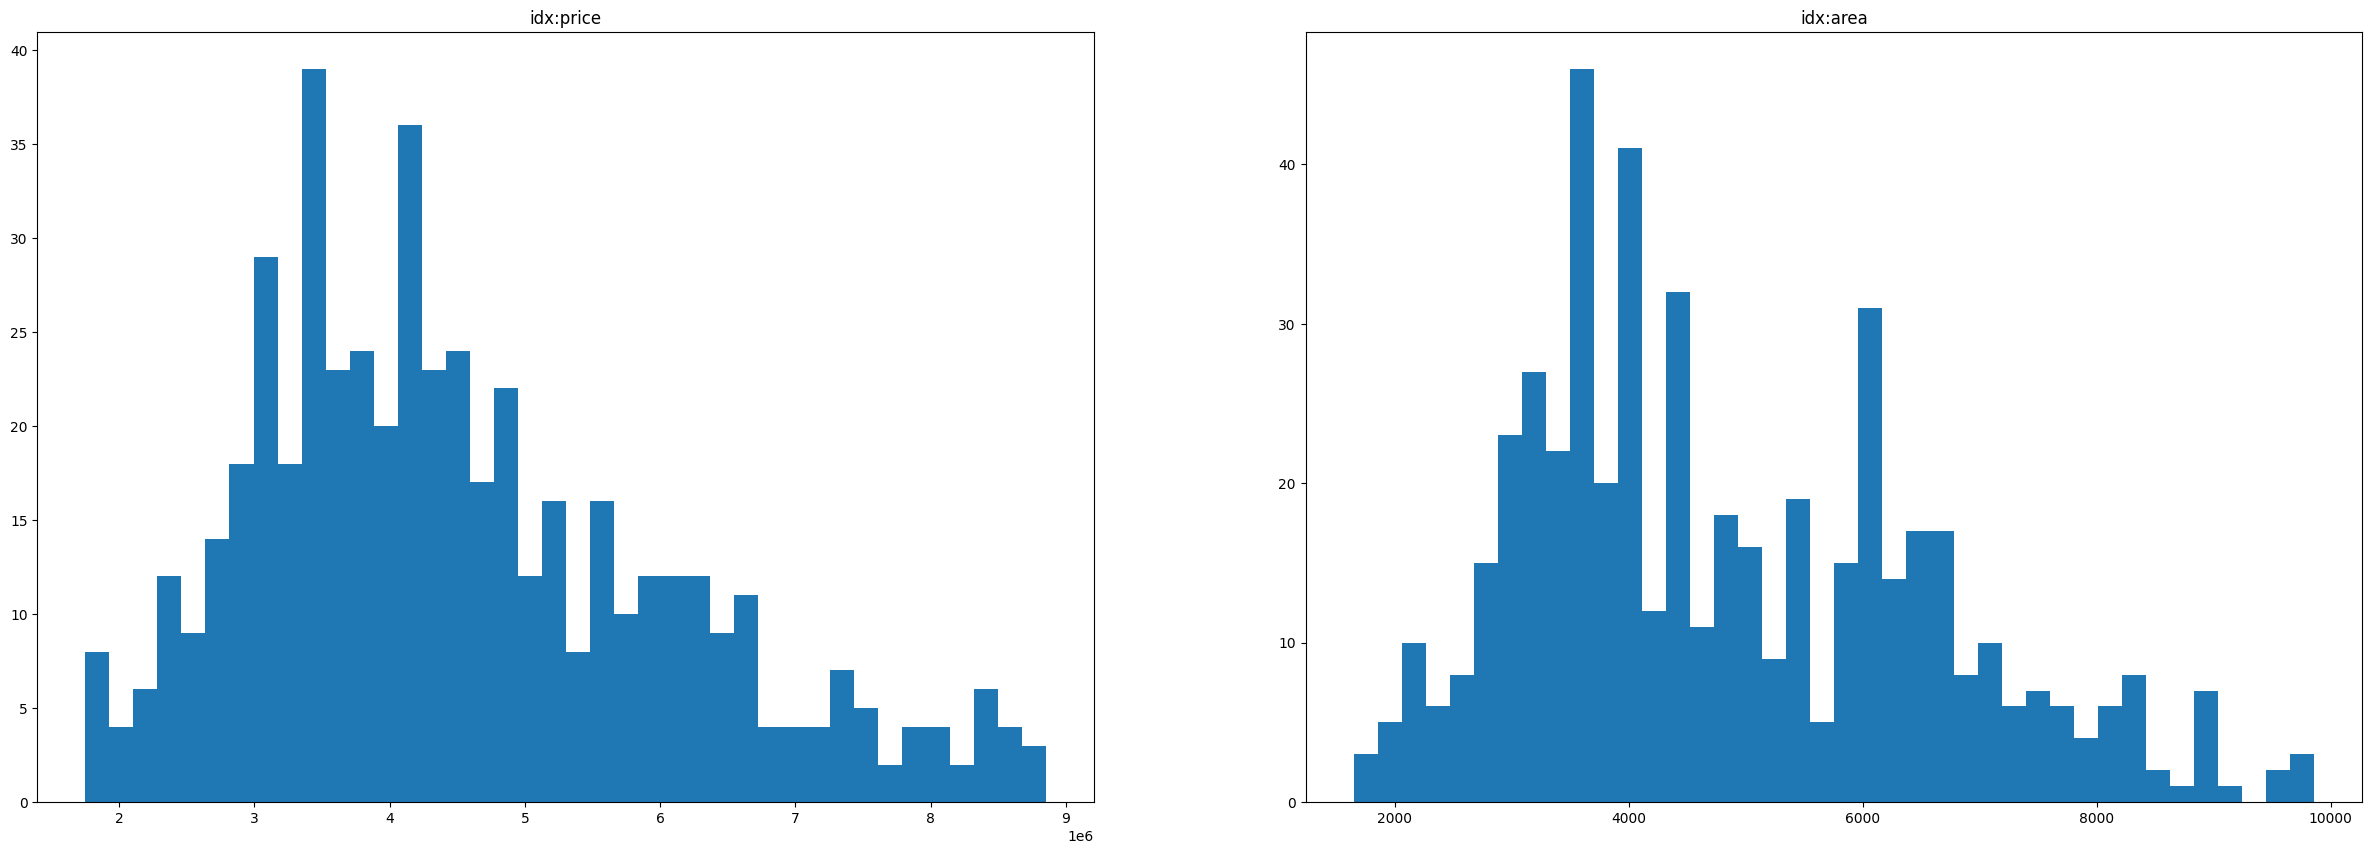

In [108]:
n_row = 1
n_col = 2

columns = list(df.columns[0:2])

fig, ax = plt.subplots(n_row, n_col, figsize=(30, 10))
ax

for idx in range(len(columns)):
    row = idx % n_row
    col = idx // n_row
    print(f'i:{idx}, col:{col}, row:{row}')

    ax[col].hist(prices[columns[idx]],bins=40)
    ax[col].set_title(f"idx:{columns[idx]}")

plt.show()

i:0, col:0, row:0
i:1, col:0, row:1
i:2, col:1, row:0
i:3, col:1, row:1
i:4, col:2, row:0
i:5, col:2, row:1
i:6, col:3, row:0
i:7, col:3, row:1
i:8, col:4, row:0
i:9, col:4, row:1


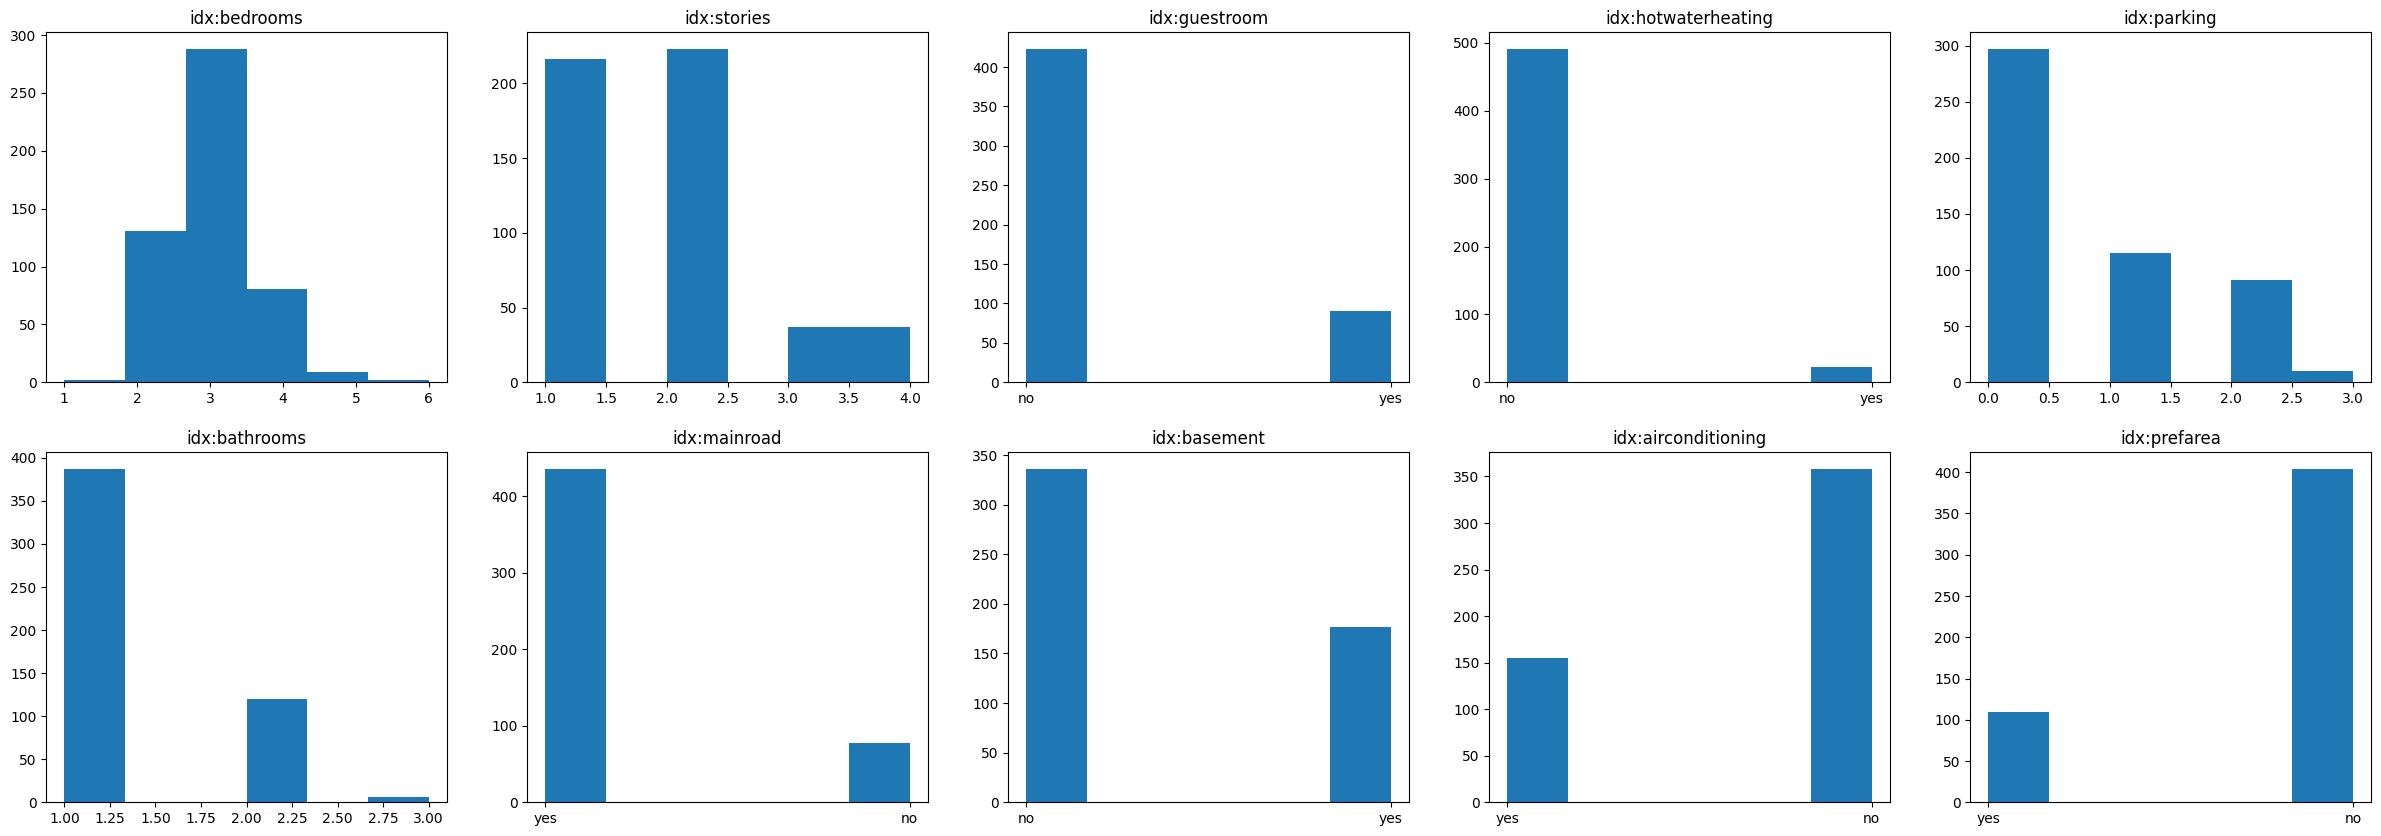

In [109]:
n_row = 2
n_col = 5

columns = list(df.columns[2:12])

fig, ax = plt.subplots(n_row, n_col, figsize=(30, 10))
ax

for idx in range(len(columns)):
    row = idx % n_row
    col = idx // n_row
    print(f'i:{idx}, col:{col}, row:{row}')

    ax[row,col].hist(prices[columns[idx]],bins=6)
    ax[row,col].set_title(f"idx:{columns[idx]}")

plt.show()

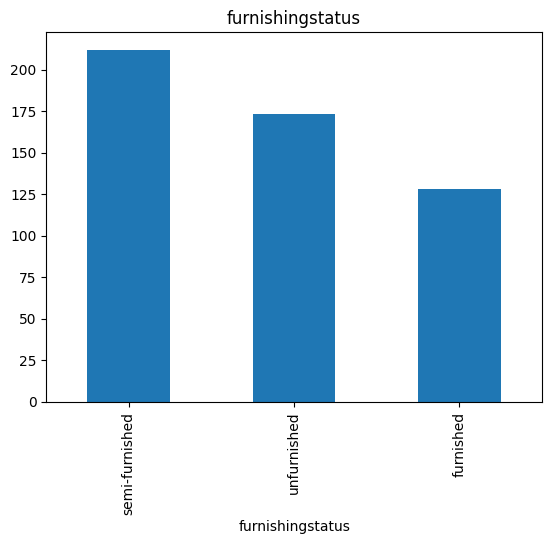

In [110]:
prices['furnishingstatus'].value_counts().plot(kind='bar')
plt.title('furnishingstatus')
plt.show()

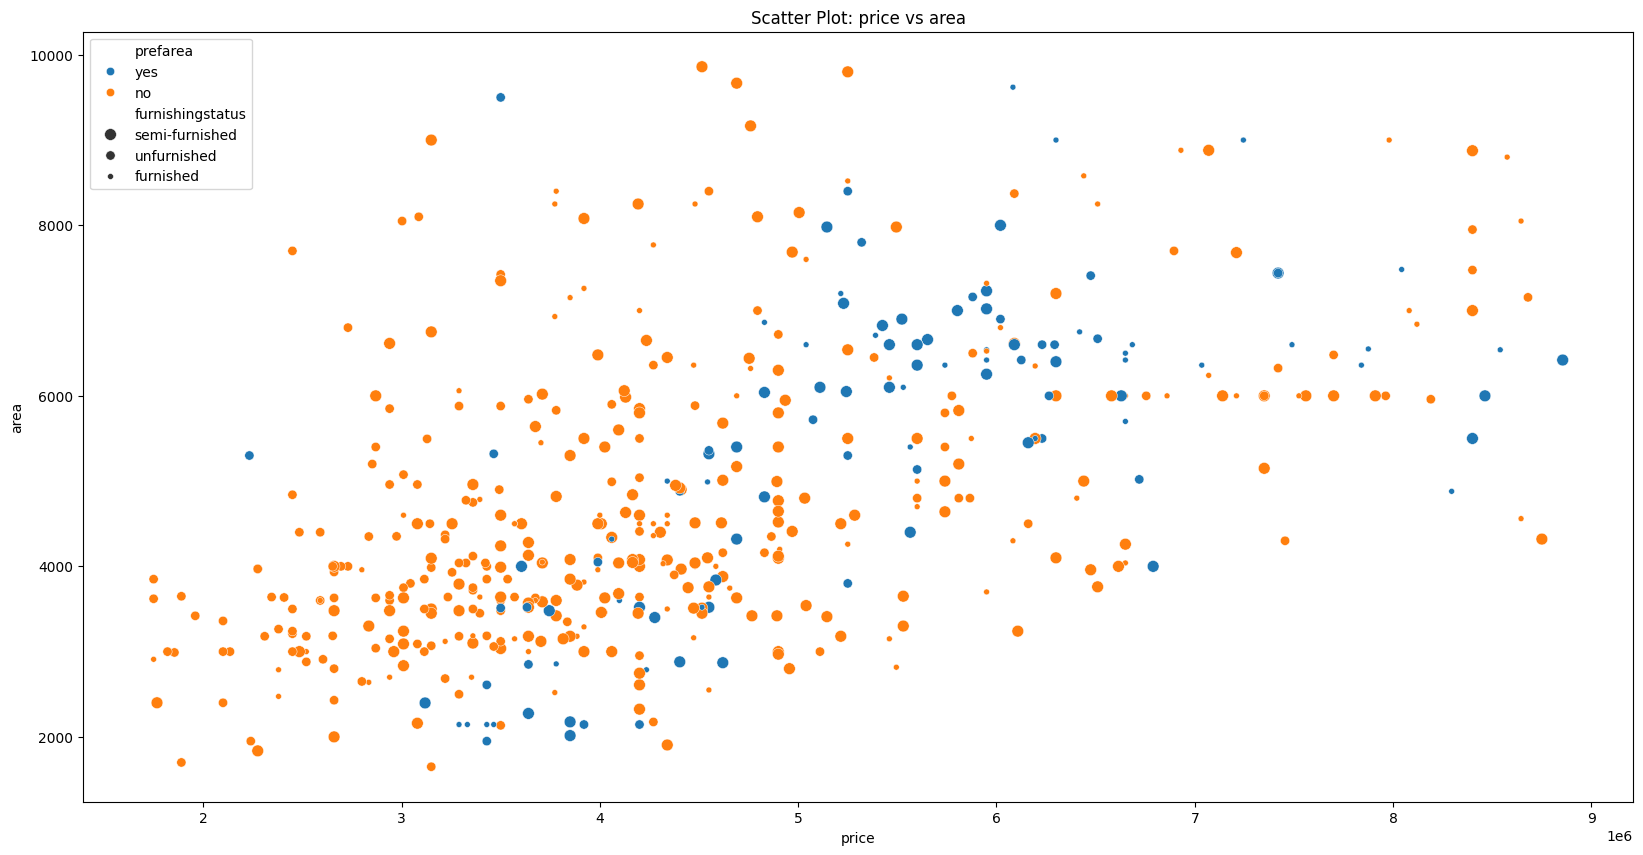

In [112]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x='price', y='area', hue= 'prefarea', data=prices,size='furnishingstatus')
plt.title('Scatter Plot: price vs area')
plt.show()

### Двумерный анализ

In [117]:
# Assemble numerical columns into a vector
assembler = VectorAssembler(inputCols=['price','area'], outputCol="features")
df_vector = assembler.transform(df).select("features")

# Compute correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").collect()[0][0]
print(correlation_matrix.toArray())



[[1.         0.54609727]
 [0.54609727 1.        ]]


In [118]:
# Cross-tabulation for categorical columns
df.crosstab("bedrooms", "stories").show()

+----------------+---+---+---+---+
|bedrooms_stories|  1|  2|  3|  4|
+----------------+---+---+---+---+
|               3| 94|141| 30| 23|
|               5|  1|  7|  1|  0|
|               6|  0|  2|  0|  0|
|               1|  2|  0|  0|  0|
|               4|  8| 54|  6| 13|
|               2|111| 19|  0|  1|
+----------------+---+---+---+---+



In [119]:
spark.stop()